In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Attention,Embedding,Dense,Input,Flatten,Concatenate,Dropout,Conv1D,GlobalMaxPool1D,BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD,Adam
from tqdm import tqdm

# Pull Gravity database

In [2]:
import functions as fn
grav_domains = fn.load_gravity(dir='').domain.values
grav_df = pd.DataFrame({'domain':grav_domains,'blocked':np.ones(len(grav_domains))})

# Pull PiHole DNS Data

In [3]:
from sqlalchemy import create_engine

db_connect = create_engine('sqlite:///pihole-FTL.db')
connection = db_connect.raw_connection()
df = pd.read_sql("SELECT * FROM queries", con=connection)
df['blocked'] = df.status.apply(lambda x: 0 if x in [2,3] else 1)           # 2,3 are domains blocked by gravity and
                                                                            # blacklist
df = pd.concat([df,grav_df]).reset_index()
#df.domain = df.domain.apply(lambda x: x.replace('.',' ').replace('-',' ')) # Model performs better leaving DNS
                                                                            # names as is

np.savetxt('domains.txt',df.domain.values,fmt="%s")
print(df.domain.head())

0    mobile.pipe.aria.microsoft.com
1    mobile.pipe.aria.microsoft.com
2             telemetry.dropbox.com
3                    login.live.com
4                    edge.skype.com
Name: domain, dtype: object


# Train/Load Tokenization Model

In [4]:
import random
import youtokentome as yttm

train_data_path = "domains.txt"
model_path = "./yttm_model/yttm_ads.model"

# Training model
yttm.BPE.train(data=train_data_path, vocab_size=300, model=model_path)

# Loading model
bpe = yttm.BPE(model=model_path)

# Two types of tokenization
print(bpe.encode(list(' '.join(df.domain.values[0].split('.'))), output_type=yttm.OutputType.ID))
print(bpe.encode(list(df.domain.values[0]), output_type=yttm.OutputType.SUBWORD))
print(' '.join(df.domain.values[0].split('.')))

[[95], [150], [114], [286], [212], [171], [], [93], [286], [93], [171], [], [165], [4, 15], [286], [165], [], [95], [286], [104], [4, 15], [150], [80], [150], [184], [130], [], [104], [150], [95]]
[['▁m'], ['▁o'], ['▁b'], ['▁i'], ['▁l'], ['▁e'], ['▁', '.'], ['▁p'], ['▁i'], ['▁p'], ['▁e'], ['▁', '.'], ['▁a'], ['▁', 'r'], ['▁i'], ['▁a'], ['▁', '.'], ['▁m'], ['▁i'], ['▁c'], ['▁', 'r'], ['▁o'], ['▁s'], ['▁o'], ['▁f'], ['▁t'], ['▁', '.'], ['▁c'], ['▁o'], ['▁m']]
mobile pipe aria microsoft com


# Siamese Model with triplet loss/metric learning

In [13]:
def build_siamese():
    
    def base_model():
        query_input = Input(shape=(30,))
        token_embedding = tf.keras.layers.Embedding(input_dim=301, output_dim=64)
        query_embeddings = token_embedding(query_input)
        qdense1 = Dense(32,activation='relu')(Flatten()(query_embeddings))
        qdense2 = Dense(32,activation='relu')(qdense1)
        qdense3 = Dense(32,activation=None)(qdense2)
        return Model(inputs=query_input,outputs=qdense3)
    
    def metric():
        inputs = Input(shape=(64,))
        d1 = Dense(64,activation='relu')(inputs)
        d2 = Dense(64,activation='relu')(d1)
        d3 = Dense(2,activation='softmax')(d2)
        return Model(inputs=inputs,outputs=d3)
    
    def triplet_loss(true,pred):
        M = 1.
        loss = tf.reduce_mean(tf.maximum(pred[:,0]**2 - pred[:,1]**2 + M,0))
        return loss
    
    def custom_acc(true,pred):
        pred_ad = tf.cast(tf.where(pred[:,0] < pred[:,1] ,1,0),tf.int16)
        total = tf.keras.backend.sum(tf.cast(pred_ad,tf.float32))
        return total/tf.cast(tf.size(pred_ad),tf.float32)
    
    input_pos = Input(shape=(30,))
    input_neg = Input(shape=(30,))
    input_anchor = Input(shape=(30,))
    
    ad_model = base_model()
    metric_model = metric()
    
    pos = ad_model(input_pos)
    anchor_pos = ad_model(input_anchor)
    neg = ad_model(input_neg)
    
    AP = metric_model(Concatenate(axis=-1)([pos,anchor_pos]))
    AN = metric_model(Concatenate(axis=-1)([neg,anchor_pos]))
    
    distances = tf.keras.layers.concatenate([AP[:,:1],AN[:,:1]],axis=1)
    
    metric_m = Model(inputs=[input_pos,input_neg,input_anchor],outputs=distances)
    metric_m.compile(optimizer=SGD(learning_rate=1e-2),loss=triplet_loss,metrics=[custom_acc])
    return metric_m

In [14]:
class model_wrapper():
    def __init__(self,ml_model,tok_model):
        self.ml_model = ml_model
        self.tok_model = tok_model
    def predict(self,x,y,z):
        encoded_x = pad_sequences(self.tok_model.encode([x], output_type=yttm.OutputType.ID),30,padding='post').reshape(1,50)
        encoded_y = pad_sequences(self.tok_model.encode([y], output_type=yttm.OutputType.ID),30,padding='post').reshape(1,50)
        encoded_z = pad_sequences(self.tok_model.encode([z], output_type=yttm.OutputType.ID),30,padding='post').reshape(1,50)
        return self.ml_model.predict([encoded_x,encoded_y,encoded_z])

In [675]:
def make_query_pairs(dframe,tokenizer,sample_count=1000):
    blacklist = dframe.loc[dframe.blocked==1].reset_index()
    whitelist = dframe.loc[dframe.blocked==0].reset_index()
    bl_len = len(blacklist)
    wl_len = len(whitelist)
    samples = sample_count
    labels = np.random.choice([-1],size=samples)
    label_out = []
    pairs = []
    anchors = []
    anchors_2 = []
    for i,l in tqdm(enumerate(labels)):
        if l == -1:
            if np.random.rand() > 0.0:
                idx1 = np.random.choice(range(bl_len))
                idx2 = np.random.choice(range(wl_len))
                pairs.append((blacklist.iloc[idx1].domain,whitelist.iloc[idx2].domain))
                label_out.append(0.)
            else:
                idx1 = np.random.choice(range(wl_len))
                idx2 = np.random.choice(range(bl_len))
                pairs.append((whitelist.iloc[idx1].domain,blacklist.iloc[idx2].domain))
                label_out.append(0.)
        else:
            if np.random.randn() > 0.5:
                idx1 = np.random.choice(range(wl_len))
                idx2 = np.random.choice(range(wl_len))
                pairs.append((whitelist.iloc[idx1].domain,whitelist.iloc[idx2].domain))
                label_out.append(1.)
            else:
                idx1 = np.random.choice(range(bl_len))
                idx2 = np.random.choice(range(bl_len))
                pairs.append((blacklist.iloc[idx1].domain,blacklist.iloc[idx2].domain))
                label_out.append(1.)
        anch_idx = np.random.choice(range(bl_len))
        anchors.append(blacklist.iloc[anch_idx].domain)
        anch_idx_2 = np.random.choice(range(wl_len))
        anchors_2.append(whitelist.iloc[anch_idx_2].domain)
    ref = [i[0] for i in pairs]
    query = [i[1] for i in pairs]
    return ref,query,anchors,anchors_2


In [ ]:
text_ads,text_no_ads,anchors_ads,anchors_no_ads = make_query_pairs(df,bpe,sample_count=100000)

text_ads = pad_sequences(list(map(lambda x: bpe.encode(x),text_ads)),30,padding='post')
text_no_ads = pad_sequences(list(map(lambda x: bpe.encode(x),text_no_ads)),30,padding='post')
anchors_ads = pad_sequences(list(map(lambda x: bpe.encode(x),anchors_ads)),30,padding='post')
anchors_no_ads = pad_sequences(list(map(lambda x: bpe.encode(x),anchors_no_ads)),30,padding='post')

61349it [1:03:30, 25.84it/s]

# Split into Train/Test

In [147]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(range(len(text_ads)),test_size=0.10, random_state=5)

ads_train = text_ads[train]
no_ads_train = text_no_ads[train]
anchor_ads_train = anchors_ads[train]
anchor_no_ads_train = anchors_no_ads[train]

ads_test = text_ads[test]
no_ads_test = text_no_ads[test]
anchor_ads_test = anchors_ads[test]
anchor_no_ads_test = anchors_no_ads[test]

In [148]:
dd_model = build_siamese() # initialize the model

In [149]:
distances = dd_model.predict([no_ads_train,ads_train,anchor_ads_train])
semi_hard_idx = (np.abs(distances[:,0]) >= 0.0)&(np.abs(distances[:,0]) <= 1.)
hist = dd_model.fit([no_ads_train[semi_hard_idx],ads_train[semi_hard_idx],anchor_no_ads_train[semi_hard_idx]],np.zeros((np.sum(semi_hard_idx),1)),epochs=500,batch_size=8,validation_data=([no_ads_test,ads_test,anchor_no_ads_test],np.zeros((len(ads_test),1))))

distances = dd_model.predict([no_ads_train,ads_train,anchor_ads_train])
pl.figure(figsize=(10,10))
pl.hist(distances[:,0],bins=30)
pl.hist(distances[:,1],bins=30,alpha=0.4)

Train on 900 samples, validate on 100 samples
Epoch 1/500
900/900 [==============================] - 3s 3ms/sample - loss: 0.9996 - custom_acc: 0.5686 - val_loss: 0.9989 - val_custom_acc: 0.6346
Epoch 2/500
900/900 [==============================] - 1s 811us/sample - loss: 0.9987 - custom_acc: 0.6250 - val_loss: 0.9976 - val_custom_acc: 0.6346
Epoch 3/500
900/900 [==============================] - 1s 819us/sample - loss: 0.9973 - custom_acc: 0.6582 - val_loss: 0.9959 - val_custom_acc: 0.6827
Epoch 4/500
900/900 [==============================] - 1s 843us/sample - loss: 0.9949 - custom_acc: 0.6759 - val_loss: 0.9931 - val_custom_acc: 0.7115
Epoch 5/500
900/900 [==============================] - 1s 827us/sample - loss: 0.9912 - custom_acc: 0.7069 - val_loss: 0.9890 - val_custom_acc: 0.7019
Epoch 6/500
900/900 [==============================] - 1s 804us/sample - loss: 0.9852 - custom_acc: 0.7069 - val_loss: 0.9825 - val_custom_acc: 0.7019
Epoch 7/500
900/900 [=============================

Epoch 55/500
900/900 [==============================] - 1s 949us/sample - loss: 0.0593 - custom_acc: 0.9613 - val_loss: 0.2516 - val_custom_acc: 0.9519
Epoch 56/500
900/900 [==============================] - 1s 968us/sample - loss: 0.0593 - custom_acc: 0.9613 - val_loss: 0.2518 - val_custom_acc: 0.9519
Epoch 57/500
900/900 [==============================] - 1s 901us/sample - loss: 0.0593 - custom_acc: 0.9602 - val_loss: 0.2517 - val_custom_acc: 0.9519
Epoch 58/500
900/900 [==============================] - 1s 852us/sample - loss: 0.0593 - custom_acc: 0.9613 - val_loss: 0.2517 - val_custom_acc: 0.9519
Epoch 59/500
900/900 [==============================] - 1s 888us/sample - loss: 0.0592 - custom_acc: 0.9624 - val_loss: 0.2516 - val_custom_acc: 0.9519
Epoch 60/500
900/900 [==============================] - 1s 998us/sample - loss: 0.0592 - custom_acc: 0.9602 - val_loss: 0.2515 - val_custom_acc: 0.9519
Epoch 61/500
900/900 [==============================] - 1s 930us/sample - loss: 0.0592 -

Epoch 109/500
900/900 [==============================] - 1s 899us/sample - loss: 0.0579 - custom_acc: 0.9635 - val_loss: 0.2479 - val_custom_acc: 0.9519
Epoch 110/500
900/900 [==============================] - 1s 877us/sample - loss: 0.0579 - custom_acc: 0.9635 - val_loss: 0.2479 - val_custom_acc: 0.9519
Epoch 111/500
900/900 [==============================] - 1s 859us/sample - loss: 0.0579 - custom_acc: 0.9635 - val_loss: 0.2479 - val_custom_acc: 0.9519
Epoch 112/500
900/900 [==============================] - 1s 827us/sample - loss: 0.0579 - custom_acc: 0.9624 - val_loss: 0.2479 - val_custom_acc: 0.9519
Epoch 113/500
900/900 [==============================] - 1s 860us/sample - loss: 0.0579 - custom_acc: 0.9635 - val_loss: 0.2480 - val_custom_acc: 0.9519
Epoch 114/500
900/900 [==============================] - 1s 906us/sample - loss: 0.0579 - custom_acc: 0.9635 - val_loss: 0.2480 - val_custom_acc: 0.9519
Epoch 115/500
900/900 [==============================] - 1s 856us/sample - loss: 0

900/900 [==============================] - 1s 882us/sample - loss: 0.0578 - custom_acc: 0.9635 - val_loss: 0.2474 - val_custom_acc: 0.9519
Epoch 163/500
900/900 [==============================] - 1s 841us/sample - loss: 0.0578 - custom_acc: 0.9635 - val_loss: 0.2474 - val_custom_acc: 0.9519
Epoch 164/500
900/900 [==============================] - 1s 836us/sample - loss: 0.0578 - custom_acc: 0.9635 - val_loss: 0.2474 - val_custom_acc: 0.9519
Epoch 165/500
900/900 [==============================] - 1s 813us/sample - loss: 0.0578 - custom_acc: 0.9635 - val_loss: 0.2474 - val_custom_acc: 0.9519
Epoch 166/500
900/900 [==============================] - 1s 889us/sample - loss: 0.0578 - custom_acc: 0.9624 - val_loss: 0.2474 - val_custom_acc: 0.9519
Epoch 167/500
900/900 [==============================] - 1s 826us/sample - loss: 0.0578 - custom_acc: 0.9635 - val_loss: 0.2474 - val_custom_acc: 0.9519
Epoch 168/500
900/900 [==============================] - 1s 817us/sample - loss: 0.0578 - custom

KeyboardInterrupt: 

(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

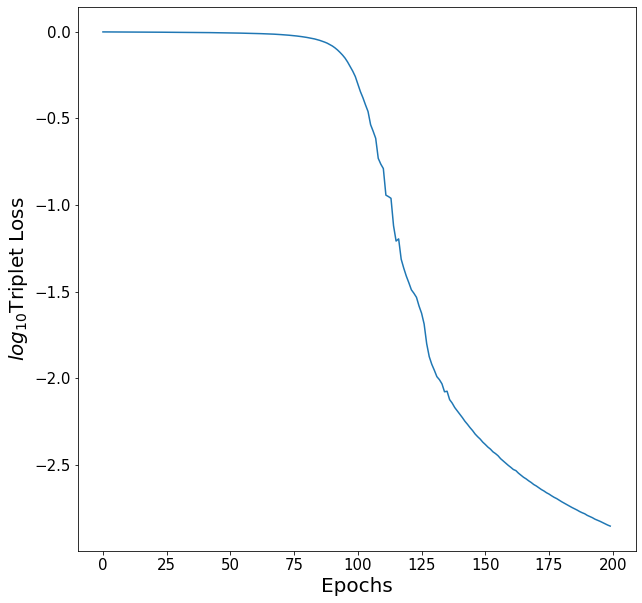

In [24]:
pl.figure(figsize=(10,10))
pl.plot(np.log10(hist.history['loss']))
pl.ylabel(r'$log_{10}$Triplet Loss',size=20)
pl.xlabel('Epochs',size=20)
pl.yticks(size=15)
pl.xticks(size=15)

# Save the Model

In [241]:
tf.keras.models.save_model(dd_model,'./models/siamese_metric_triplet_loss.h5')
# Example loading model back up with custom loss and accuracy
# model = tf.keras.models.load_model('./models/siamese_metric_triplet_loss.h5',custom_objects={'triplet_loss':triplet_loss,'custom_acc':custom_acc})

# Further Model Testing

In [663]:
# Load new test dataset
test_ref,test_query,test_anchors_1,test_anchors_2 = make_query_pairs(df,bpe,sample_count=100)
test_ref_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_ref)),30,padding='post')
test_query_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_query)),30,padding='post')
test_anchors_1_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_anchors_1)),30,padding='post')
test_anchors_2_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_anchors_2)),30,padding='post')

100it [00:03, 25.19it/s]


In [671]:
domain_stat_test = pad_sequences(100*[bpe.encode('play.hulu.com')],30,padding='post')

In [672]:
domain_test_distances = dd_model.predict([domain_stat_test,test_ref_enc,test_anchors_2_enc])
print('Prob. domain is ad server: {0}%'.format(100.*np.sum((domain_test_distances[:,0]>=domain_test_distances[:,1]))/len(domain_test_distances)))

Prob. domain is ad server: 68.0%


In [674]:
def multi_pred(model,query,neg_list,anchor_list):
    print(np.shape(anchor_list))
    predictions = model.predict([query,neg_list,anchor_list])
    return (predictions[:,0]>=predictions[:,1]).mean()

multi_pred(dd_model,domain_stat_test,test_ref_enc,test_anchors_2_enc)
domain_test_distances
#(domain_test_distances[:,0]>=domain_test_distances[:,1]).mean()

(100, 30)


array([[0.99999964, 0.99999905],
       [0.99999964, 0.9964575 ],
       [0.99999976, 0.24419302],
       [0.99999976, 0.9980028 ],
       [0.99999976, 0.9979327 ],
       [0.99999964, 0.99999917],
       [0.99999964, 0.9970901 ],
       [0.99999976, 0.00866058],
       [0.99999976, 0.9999995 ],
       [0.99999976, 0.99999964],
       [0.99999976, 0.999998  ],
       [0.99999976, 0.9999999 ],
       [0.99999976, 0.9999956 ],
       [0.99999964, 1.        ],
       [0.99999976, 0.99999976],
       [0.99999976, 1.        ],
       [0.99999976, 1.        ],
       [0.99999976, 0.9999995 ],
       [0.99999976, 0.99810827],
       [0.99999976, 0.9993337 ],
       [0.99999976, 0.9999995 ],
       [0.99999976, 0.9999635 ],
       [0.99999976, 1.        ],
       [0.99999976, 0.9999994 ],
       [0.99999976, 0.9999857 ],
       [0.99999976, 1.        ],
       [0.9999995 , 0.99999475],
       [0.99999976, 0.999635  ],
       [0.99999976, 0.99999964],
       [0.99999976, 0.99987507],
       [0.

# Look at Ad/No Ad Domains in Embedding

In [182]:
embed_model = Model(dd_model.layers[3].layers[1].input,dd_model.layers[3].layers[5].output)

In [183]:
ads = embed_model.predict(test_ref_enc)
no_ads = embed_model.predict(test_query_enc)
no_ad_anchor = embed_model.predict(test_anchors_2_enc)

In [184]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2).fit(np.vstack((no_ads,ads)))
pca_no_ads = pca_model.transform(no_ads)
pca_ads = pca_model.transform(ads)
pca_anchor = pca_model.transform(no_ad_anchor)

/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


([], [])

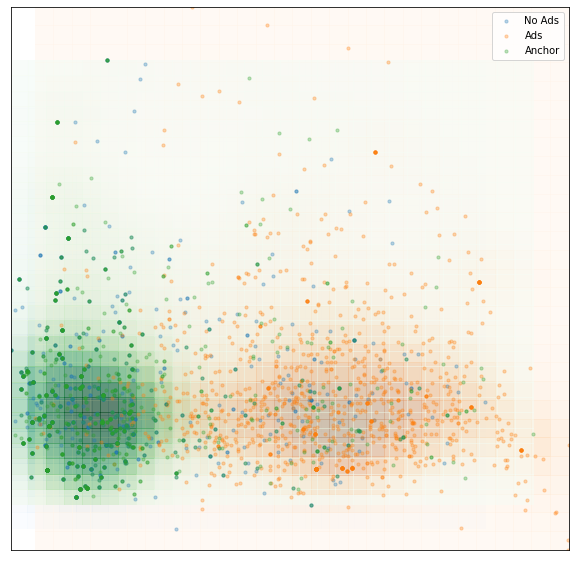

In [240]:
from scipy.stats import kde
def kde_plot(x,y,colors=None):
    nbins=30
    k = kde.gaussian_kde([x,y])
    xi, yi = np.mgrid[min(x):max(x):nbins*1j, min(y):max(y):nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    pl.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=colors, alpha=0.5)


pl.figure(figsize=(10,10))
kde_plot(pca_no_ads[:,0],pca_no_ads[:,1],colors='Blues')
kde_plot(pca_ads[:,0],pca_ads[:,1],colors='Oranges')
kde_plot(pca_anchor[:,0],pca_anchor[:,1],colors='Greens')
#pl.hist2d(pca_no_ads[:,0],pca_no_ads[:,1],bins=20,cmap='Blues',density=True,alpha=0.3)
#pl.hist2d(pca_ads[:,0],pca_ads[:,1],bins=20,cmap='Oranges',density=True,alpha=0.3)
#pl.hist2d(pca_anchor[:,0],pca_anchor[:,1],bins=20,cmap='Greens',density=True,alpha=0.3)
pl.scatter(pca_no_ads[:,0],pca_no_ads[:,1],s=10,alpha=0.3,label='No Ads')
pl.scatter(pca_ads[:,0],pca_ads[:,1],s=10,alpha=0.3,label='Ads')
pl.scatter(pca_anchor[:,0],pca_anchor[:,1],s=10,alpha=0.3,label='Anchor')
pl.legend()
pl.xticks([])
pl.yticks([])

# Online Training Tests

In [623]:
# Reload model
def triplet_loss(true,pred):
    M = 1.
    loss = tf.reduce_mean(tf.maximum(pred[:,0]**2 - pred[:,1]**2 + M,0))
    return loss
    
def custom_acc(true,pred):
    pred_ad = tf.cast(tf.where(pred[:,0] < pred[:,1] ,1,0),tf.int16)
    total = tf.keras.backend.sum(tf.cast(pred_ad,tf.float32))
    return total/tf.cast(tf.size(pred_ad),tf.float32)

online_model = tf.keras.models.load_model('./models/siamese_metric_triplet_loss.h5',custom_objects={'triplet_loss':triplet_loss,'custom_acc':custom_acc})
online_model.optimizer.lr = 1e-4

In [628]:
dist_true = []
dist_false = []
dist_3rd = []

test_ref,test_query,test_anchors_1,test_anchors_2 = make_query_pairs(df,bpe,sample_count=500)
test_ref_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_ref)),30,padding='post')
test_query_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_query)),30,padding='post')
test_anchors_1_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_anchors_1)),30,padding='post')
test_anchors_2_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_anchors_2)),30,padding='post')


for i in range(500):
    if i%2==0:
        request = np.random.choice(df.domain.values)
    else:
        request = np.random.choice(['googleadserver.com','www.slack.com'])
    domain_stat_test = pad_sequences(1*[bpe.encode(request)],30,padding='post')

    init_preds = online_model.predict([domain_stat_test,test_ref_enc[i].reshape(1,-1),test_anchors_2_enc[i].reshape(1,-1)])
    #if (init_preds[:,0]>=init_preds[:,1]).mean() > 0.5:
    if (init_preds[:,0] > 0.55) & (init_preds[:,0] < 0.9):
        online_model.fit([test_query_enc[i].reshape(1,-1),domain_stat_test,test_anchors_2_enc[i].reshape(1,-1)],np.zeros(1),epochs=1)
    elif (init_preds[:,0] > 0.1) & (init_preds[:,0] < 0.45):
        online_model.fit([domain_stat_test,test_ref_enc[i].reshape(1,-1),test_anchors_2_enc[i].reshape(1,-1)],np.zeros(1),epochs=1)
    #print(init_preds)
    print('Domain is ad server(pre): ',(init_preds[:,0]>=init_preds[:,1]).mean())
    post_preds = online_model.predict([domain_stat_test,test_ref_enc[i].reshape(1,-1),test_anchors_2_enc[i].reshape(1,-1)])
    #print(post_preds)
    print('Domain is ad server(post): ',(post_preds[:,0]>=post_preds[:,1]).mean())
    if request == 'googleadserver.com':
        dist_true.append(post_preds[:,0][0])
    elif request == 'www.slack.com':
        dist_false.append(post_preds[:,0][0])
    test_case = pad_sequences(1*[bpe.encode('c.aaxads.com')],30,padding='post') 
    test_pred = online_model.predict([test_case,test_ref_enc[i].reshape(1,-1),test_anchors_2_enc[i].reshape(1,-1)])
    dist_3rd.append(test_pred[:,0][0])

500it [00:20, 24.53it/s]


Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post

Domain is ad server(post):  1.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre

Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  1.0
Domain is ad server(post

Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  1.0
Domain is ad server(post):  1.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  0.0
Domain is ad server(post):  0.0
Domain is ad server(pre):  1.0
Domain is ad server(post

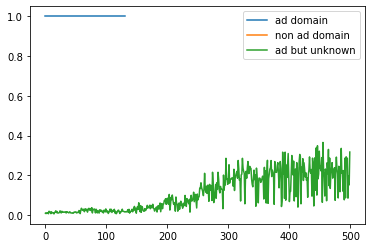

In [627]:
pl.plot(dist_true,label='ad domain')
pl.plot(dist_false,label='non ad domain')
pl.plot(dist_3rd,label='ad but unknown')
pl.legend()

In [592]:
domain_stat_test = pad_sequences(1*[bpe.encode('www.popville.com')],30,padding='post')
test_ref,test_query,test_anchors_1,test_anchors_2 = make_query_pairs(df,bpe,sample_count=1)
test_ref_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_ref)),30,padding='post')
test_query_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_query)),30,padding='post')
test_anchors_1_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_anchors_1)),30,padding='post')
test_anchors_2_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_anchors_2)),30,padding='post')

init_preds = online_model.predict([domain_stat_test,test_ref_enc,test_anchors_2_enc])
print(init_preds)

1it [00:00, 21.32it/s]

[[0.04769848 1.        ]]


In [603]:
domain_test_distances

array([[0.9949765 , 0.9997305 ],
       [0.9965162 , 0.9999994 ],
       [0.992152  , 0.93769884],
       [0.9949125 , 0.9997861 ],
       [0.9818986 , 0.9999126 ],
       [0.996438  , 0.8922605 ],
       [0.99557436, 0.9999995 ],
       [0.99672526, 0.99994993],
       [0.9958385 , 1.        ],
       [0.9815253 , 0.99999857],
       [0.99667263, 1.        ],
       [0.9923894 , 1.        ],
       [0.97737634, 1.        ],
       [0.9959014 , 1.        ],
       [0.9962528 , 0.9999993 ],
       [0.9895521 , 0.99999976],
       [0.99628603, 0.00563292],
       [0.9956468 , 0.9999999 ],
       [0.9949254 , 0.9999994 ],
       [0.9962196 , 0.99992144],
       [0.9963167 , 1.        ],
       [0.99718386, 0.9651092 ],
       [0.9970873 , 0.9841531 ],
       [0.99608237, 0.9999999 ],
       [0.9966382 , 1.        ],
       [0.9948402 , 0.9999515 ],
       [0.9953206 , 1.        ],
       [0.99661785, 0.9997639 ],
       [0.99643373, 0.72801524],
       [0.9973333 , 0.9911513 ],
       [0.